In [1]:
import random
import string
import torch
import wandb

import numpy as np
import pandas as pd

from Code import Dataloader
from Code import Dataset
from Code import ModelBertV1
from Code import Train

from sklearn.model_selection import train_test_split

In [2]:
# import Code.Dataloader as loader
# fetcher = loader.SyncBatchEthFetcher(batch_size=500)
# last_ind = int(2e7 + 1e6)
# size = 100_000

# df_txs = fetcher.get_transactions(last_ind - size, last_ind, use_async=False)

In [3]:
import Code.ModelBertV1 as ModelLib
model = ModelLib.BertForTransactionRegressionV1(100, 32, False, 12, 15)

In [4]:
import torch

def load_model(model, path, map_location='cuda'):
    checkpoint = torch.load(path, map_location=map_location, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    config = checkpoint.get('config', None)
    epoch = checkpoint.get('epoch', None)

    return model, config, epoch

In [5]:
model, config, epoch = load_model(model,
                                  '/home/motatasher/Documents/University/Diploma/' \
                                  'Diploma/models/model training on eth dataset v1, ' \
                                  'tensor predict_qjmctedofg/model_epoch_151.pt')
config['df_config']['address_limit'] = 100

In [6]:
config

{'name': 'model training on eth dataset v1, tensor predict',
 'df_config': {'cnt': 50000, 'start_block': 20900000, 'end_block': 21000000, 'address_limit': 100, 'use_async': False},
 'dataset_fabric': 'GetEthereumDataset',
 'train_batch_size': 512,
 'test_batch_size': 64,
 'sample_len': 100,
 'cnt_known_address': 100,
 'model': 'BertForTransactionRegressionV1',
 'model_params': {'emb_size': 32, 'num_attention_heads': 12, 'use_compositor': False, 'time_features': 15},
 'num_epochs': 1000,
 'learning_rate': 3e-05,
 'gamma': 0.3,
 'step_size': 10,
 'warmup_epochs': 10,
 'time_coef_loss': 1,
 'cnt_last_for_show': 50,
 'seconds_betwen_image_show': 10,
 'model_predictor': 'time_cross_predictior',
 'result_loss': <function Code.Train.result_loss_slower_change(result, coef, **kwargs) -> torch.Tensor>,
 'show_img': False,
 'show_batch_size': 100,
 'p_change': 0.15,
 'p_msk': 0.15,
 'p_save': 0.15,
 'loggin_each': 5,
 'change_strategy': <function Code.Train.uniform_change_strategy(shape) -> torch

In [7]:
config['df_config']

{'cnt': 50000, 'start_block': 20900000, 'end_block': 21000000, 'address_limit': 100, 'use_async': False}

In [8]:
start_block = 21100000
end_block = 21200000

address_limit = 100
use_async = False

In [9]:
Dataloader.GetEthereumDataset(
    start_block=start_block,
    end_block=end_block,
    address_limit=address_limit,
    use_async=use_async,
)

  0%|          | 0/200 [00:00<?, ?it/s]

Write at logger: logs/logs_470.log


KeyboardInterrupt: 

In [ ]:
df_raw = getattr(Dataloader, config['dataset_fabric'])(**config['df_config'])

In [6]:

df_raw = getattr(Dataloader, config['dataset_fabric'])(**config['df_config'])
print(config['cnt_known_address'])
known_address = pd.concat([df_raw['to'], df_raw['from']])\
                    .value_counts()[:config['cnt_known_address']]\
                    .keys().sort_values()

dataset_params = {
    'known_address': list(known_address),
    'sample_len': config['sample_len']
}

train_data, val_data = train_test_split(df_raw, test_size=1/4, shuffle=False)
print(f"square std of all: {df_raw['value'].std() ** 2}\nTrain: {train_data['value'].std() ** 2}\nVal: {val_data['value'].std() ** 2}")

train_loader = torch.utils.data.DataLoader(
    Dataset.TransactionDataset(train_data, **dataset_params, apply_log=config['use_log']),
    batch_size=config['train_batch_size'],
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    Dataset.TransactionDataset(val_data, **dataset_params, apply_log=config['use_log']),
    batch_size=config['test_batch_size'],
    shuffle=False,
)


  0%|          | 0/200 [00:00<?, ?it/s]

Write at logger: logs/logs_448.log
100
square std of all: 9339.154819480005
Train: 7457.256819637733
Val: 14984.751685044885


In [7]:
device = 'cuda:5'

In [8]:
model = model.to(device)

In [9]:
train_data.timestamp = pd.to_datetime(train_data.timestamp * 1e9)
val_data.timestamp = pd.to_datetime(val_data.timestamp * 1e9)

In [10]:
# df_raw.iloc[:1024]

In [11]:
# np.array(df_raw['timestamp']).astype('datetime64[s]')

In [12]:
pd.to_datetime(0)

Timestamp('1970-01-01 00:00:00')

In [271]:
import itertools
from tqdm import tqdm

def get_ts(data):
    # return (pd.to_datetime(data['timestamp'] * 1e9) -  pd.to_datetime(0)).values \
    #         / np.timedelta64(1, 'ns')
    return (data.loc[:, 'timestamp'].values.astype('datetime64[ns]') -  np.datetime64('1970-01-01T00:00:00')) \
            / np.timedelta64(1, 'ns')
    # return data['timestamp'].values * 1e9

from torch.utils import data
from torch.utils.data import DataLoader
from tqdm import tqdm

class TimeEmbeddingRegressionDataset(data.Dataset):
    def __init__(self, df, model, sample_len, apply_log=False,
                 device='cuda', batch_size=128, cnt_batchs=8):
        self.model = model.eval().to(device)
        self.df = df.reset_index(drop=True)
        self.sample_len = sample_len
        self.apply_log = apply_log
        self.device = device
        self.batch_size = batch_size
        self.cnt_batchs = cnt_batchs

        self.samples = self.build_samples(df)
        self.embeddings, self.targets = self.compute_all_embeddings()

    def build_samples(self, df):
        return list(range(
            min(len(df), self.batch_size * self.sample_len * self.cnt_batchs) // self.sample_len * self.sample_len))

    def __len__(self):
        return len(self.samples)

    def compute_all_embeddings(self):
        all_embs, all_tgts = [], []
        loader = DataLoader(self.samples[::self.sample_len], batch_size=self.batch_size, shuffle=True)

        for batch_indices in tqdm(itertools.islice(loader, self.cnt_batchs), desc="Embedding calculation", total=
                                  min(self.cnt_batchs, len(loader))):
            batch = [self._prepare_sample(int(idx)) for idx in batch_indices]
            # print(batch_indices)
            # print(batch[0])

            model_inputs = self._collate_inputs([b[0] for b in batch])
            targets = torch.stack([b[1] for b in batch]).to(self.device)

            with torch.no_grad():
                result = self.model(**model_inputs)['result']

            all_embs.append(result.cpu())
            all_tgts.append(targets.cpu())

        print(torch.cat(all_embs, 0).shape)
        return torch.cat(all_embs, 0).reshape(-1, all_embs[0].shape[-1]), torch.cat(all_tgts, 0).reshape(-1, 1)

    def _prepare_sample(self, idx):
        i = idx
        batch_df = self.df.iloc[i:i + self.sample_len]
        ts = get_ts(batch_df)
        time_features = Dataset.extract_time_features(ts)
        from_ind = batch_df['from'].values
        to_ind = batch_df['to'].values
        values = batch_df['value'].values

        volume_converter = lambda x: x
        if self.apply_log:
            volume_converter = lambda x: np.log(x)

        sample = {
            'numeric_features': torch.tensor(values, dtype=torch.float).T.unsqueeze(0).unsqueeze(-1),
            'from_address': torch.tensor(from_ind, dtype=torch.long).T.unsqueeze(0),
            'to_address': torch.tensor(to_ind, dtype=torch.long).T.unsqueeze(0),
            'time_features': torch.tensor(time_features, dtype=torch.float).T.unsqueeze(0),
            'value': torch.tensor(volume_converter(values)).unsqueeze(0).unsqueeze(-1)
        }

        msk_ind, change_ind, save_ind, model_input = Train.batch_to_model(
            sample,
            p_msk=0.0,
            p_change=0.0,
            p_save=1.0,
            device=self.device,
            change_strategy=Train.uniform_change_strategy
        )

        target = torch.tensor(ts, dtype=torch.float)
        return model_input, target

    def _collate_inputs(self, input_list):
        batched = {}
        for key in input_list[0].keys():
            batched[key] = torch.cat([torch.tensor(item[key]) for item in input_list], dim=0)
        return batched

    def __getitem__(self, idx):
        return self.embeddings[idx], self.targets[idx]


In [272]:
eazy_df = TimeEmbeddingRegressionDataset(df_raw, model, 100, apply_log=True, cnt_batchs=400)

Embedding calculation:   0%|          | 0/95 [00:00<?, ?it/s]/tmp/ipykernel_2006552/1555572793.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batched[key] = torch.cat([torch.tensor(item[key]) for item in input_list], dim=0)
Embedding calculation: 100%|██████████| 95/95 [00:09<00:00,  9.65it/s]


torch.Size([12148, 100, 64])


In [225]:
eazy_df[:][1].mean()

tensor(1.7290e+09)

In [220]:
from copy import deepcopy


copy_value = deepcopy( eazy_df[:][1])

In [232]:
(eazy_df[:][1] - copy_value).abs().max()

tensor(0.)

In [227]:
eazy_df[:][1] -= eazy_df[:][1].mean()

TypeError: 'tuple' object does not support item assignment

In [147]:
len(eazy_df)

512000

In [193]:
import datetime

In [194]:
datetime.timedelta(seconds=1)

datetime.timedelta(seconds=1)

In [278]:
# nn.MSELoss()(
#     torch.tensor([3.]),
#     torch.tensor([5.])
# )

In [302]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

class SimpleRegressor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        return self.net(x)

def train_time_regressor(model, dataloader, num_epochs=100, lr=10, device='cuda', std=1, mean=0):
    std = float(std)
    mean = float(mean)
    model = model.to(device)
    # optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-7
    )

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for emb_time, target in tqdm(dataloader, desc=f"Epoch {epoch + 1}"):
            # print(emb_time.shape,  emb_time.norm(2, 0).shape)
            emb_time = emb_time / emb_time.norm(2, 0)
            emb_time = emb_time.to(device)
            target = (target.to(device).unsqueeze(-1).float() - mean) / std

            # pred = model(emb_time)
            # loss = criterion(pred, target)
            def closure():
                optimizer.zero_grad()
                preds = model(emb_time)
                loss = criterion(preds, target)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()

            total_loss += loss.item()

        scheduler.step(total_loss / len(dataloader))
        # scheduler.get_lr()
        avg_loss = (total_loss / len(dataloader)) ** 0.5 * std
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1}\nLr: {current_lr}\nLoss: {avg_loss:.4f}\ntimedelta {datetime.timedelta(seconds=avg_loss)}")


In [303]:
pd.to_datetime(eazy_df[:][1].max() * 1e9) - pd.to_datetime(eazy_df[:][1].min() * 1e9)

Timedelta('13 days 16:31:02.194626560')

In [304]:
time_model = SimpleRegressor(32)

In [306]:
dataloader =  DataLoader(eazy_df, 2 ** 14, drop_last=True, num_workers=12, persistent_workers=True, pin_memory=True)

In [307]:
train_time_regressor(time_model, dataloader,
                     lr=1, device=device, std=eazy_df[:][1].std(), mean=eazy_df[:][1].mean())

/home/motatasher/miniconda3/envs/DiplomaIsupov/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1:   0%|          | 0/74 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a131c3060>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a131c3060>  File "/home/motatasher/miniconda3/envs/DiplomaIsupov/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5a131c3060>
    
self._shutdown_workers()Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/motatasher/miniconda3/envs/DiplomaIsupov/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/motata

Epoch 1
Lr: 1
Loss: 273047.6362
timedelta 3 days, 3:50:47.636164


Epoch 2: 100%|██████████| 74/74 [00:02<00:00, 25.04it/s]


Epoch 2
Lr: 1
Loss: 265231.1123
timedelta 3 days, 1:40:31.112309


Epoch 3: 100%|██████████| 74/74 [00:02<00:00, 29.35it/s]


Epoch 3
Lr: 1
Loss: 265633.3799
timedelta 3 days, 1:47:13.379944


Epoch 4: 100%|██████████| 74/74 [00:02<00:00, 27.84it/s]


Epoch 4
Lr: 1
Loss: 265025.7394
timedelta 3 days, 1:37:05.739438


Epoch 5: 100%|██████████| 74/74 [00:02<00:00, 34.49it/s]


Epoch 5
Lr: 1
Loss: 265024.0446
timedelta 3 days, 1:37:04.044611


Epoch 6: 100%|██████████| 74/74 [00:01<00:00, 52.44it/s]


Epoch 6
Lr: 1
Loss: 264940.1975
timedelta 3 days, 1:35:40.197486


Epoch 7: 100%|██████████| 74/74 [00:01<00:00, 42.66it/s]


Epoch 7
Lr: 1
Loss: 264904.1834
timedelta 3 days, 1:35:04.183427


Epoch 8: 100%|██████████| 74/74 [00:02<00:00, 32.07it/s]


Epoch 8
Lr: 1
Loss: 264949.1283
timedelta 3 days, 1:35:49.128296


Epoch 9: 100%|██████████| 74/74 [00:02<00:00, 32.89it/s]


Epoch 9
Lr: 1
Loss: 265008.9600
timedelta 3 days, 1:36:48.960040


Epoch 10: 100%|██████████| 74/74 [00:02<00:00, 36.20it/s]


Epoch 10
Lr: 1
Loss: 265052.1003
timedelta 3 days, 1:37:32.100259


Epoch 11: 100%|██████████| 74/74 [00:01<00:00, 51.39it/s]


Epoch 11
Lr: 1
Loss: 265074.4028
timedelta 3 days, 1:37:54.402834


Epoch 12: 100%|██████████| 74/74 [00:02<00:00, 35.81it/s]


Epoch 12
Lr: 1
Loss: 265081.2735
timedelta 3 days, 1:38:01.273540


Epoch 13: 100%|██████████| 74/74 [00:02<00:00, 33.39it/s]


Epoch 13
Lr: 0.5
Loss: 265078.6709
timedelta 3 days, 1:37:58.670887


Epoch 14: 100%|██████████| 74/74 [00:02<00:00, 28.08it/s]


Epoch 14
Lr: 0.5
Loss: 264239.5431
timedelta 3 days, 1:23:59.543148


Epoch 15: 100%|██████████| 74/74 [00:02<00:00, 26.31it/s]


Epoch 15
Lr: 0.5
Loss: 264679.7003
timedelta 3 days, 1:31:19.700272


Epoch 16: 100%|██████████| 74/74 [00:02<00:00, 30.05it/s]


Epoch 16
Lr: 0.5
Loss: 264731.3862
timedelta 3 days, 1:32:11.386237


Epoch 17: 100%|██████████| 74/74 [00:01<00:00, 40.32it/s]


Epoch 17
Lr: 0.5
Loss: 264752.9763
timedelta 3 days, 1:32:32.976259


Epoch 18: 100%|██████████| 74/74 [00:02<00:00, 36.94it/s]


Epoch 18
Lr: 0.5
Loss: 264771.0972
timedelta 3 days, 1:32:51.097206


Epoch 19: 100%|██████████| 74/74 [00:02<00:00, 32.17it/s]


Epoch 19
Lr: 0.5
Loss: 264787.0784
timedelta 3 days, 1:33:07.078403


Epoch 20: 100%|██████████| 74/74 [00:02<00:00, 32.10it/s]


Epoch 20
Lr: 0.25
Loss: 264801.3861
timedelta 3 days, 1:33:21.386070


Epoch 21: 100%|██████████| 74/74 [00:02<00:00, 35.35it/s]


Epoch 21
Lr: 0.25
Loss: 264269.0225
timedelta 3 days, 1:24:29.022478


Epoch 22: 100%|██████████| 74/74 [00:01<00:00, 46.54it/s]


Epoch 22
Lr: 0.25
Loss: 264125.0216
timedelta 3 days, 1:22:05.021590


Epoch 23: 100%|██████████| 74/74 [00:02<00:00, 35.73it/s]


Epoch 23
Lr: 0.25
Loss: 264113.2801
timedelta 3 days, 1:21:53.280080


Epoch 24: 100%|██████████| 74/74 [00:02<00:00, 30.93it/s]


Epoch 24
Lr: 0.25
Loss: 264092.0019
timedelta 3 days, 1:21:32.001927


Epoch 25: 100%|██████████| 74/74 [00:02<00:00, 30.58it/s]


Epoch 25
Lr: 0.25
Loss: 264069.8556
timedelta 3 days, 1:21:09.855590


Epoch 26: 100%|██████████| 74/74 [00:02<00:00, 28.29it/s]


Epoch 26
Lr: 0.25
Loss: 264047.8332
timedelta 3 days, 1:20:47.833238


Epoch 27: 100%|██████████| 74/74 [00:01<00:00, 38.23it/s]


Epoch 27
Lr: 0.25
Loss: 264026.5147
timedelta 3 days, 1:20:26.514652


Epoch 28: 100%|██████████| 74/74 [00:01<00:00, 47.92it/s]


Epoch 28
Lr: 0.25
Loss: 264006.3061
timedelta 3 days, 1:20:06.306100


Epoch 29: 100%|██████████| 74/74 [00:01<00:00, 37.38it/s]


Epoch 29
Lr: 0.25
Loss: 263987.4823
timedelta 3 days, 1:19:47.482284


Epoch 30: 100%|██████████| 74/74 [00:02<00:00, 33.34it/s]


Epoch 30
Lr: 0.25
Loss: 263970.2183
timedelta 3 days, 1:19:30.218275


Epoch 31: 100%|██████████| 74/74 [00:02<00:00, 31.42it/s]


Epoch 31
Lr: 0.25
Loss: 263954.5906
timedelta 3 days, 1:19:14.590630


Epoch 32: 100%|██████████| 74/74 [00:01<00:00, 39.77it/s]


Epoch 32
Lr: 0.25
Loss: 263940.6162
timedelta 3 days, 1:19:00.616221


Epoch 33: 100%|██████████| 74/74 [00:01<00:00, 50.43it/s]


Epoch 33
Lr: 0.25
Loss: 263928.2601
timedelta 3 days, 1:18:48.260139


Epoch 34: 100%|██████████| 74/74 [00:01<00:00, 39.14it/s]


Epoch 34
Lr: 0.25
Loss: 263917.4585
timedelta 3 days, 1:18:37.458497


Epoch 35: 100%|██████████| 74/74 [00:02<00:00, 29.38it/s]


Epoch 35
Lr: 0.25
Loss: 263908.1110
timedelta 3 days, 1:18:28.111032


Epoch 36: 100%|██████████| 74/74 [00:02<00:00, 34.37it/s]


Epoch 36
Lr: 0.25
Loss: 263900.1076
timedelta 3 days, 1:18:20.107619


Epoch 37: 100%|██████████| 74/74 [00:02<00:00, 31.88it/s]


Epoch 37
Lr: 0.25
Loss: 263893.3349
timedelta 3 days, 1:18:13.334930


Epoch 38: 100%|██████████| 74/74 [00:01<00:00, 38.74it/s]


Epoch 38
Lr: 0.25
Loss: 263887.6616
timedelta 3 days, 1:18:07.661645


Epoch 39: 100%|██████████| 74/74 [00:01<00:00, 41.75it/s]


Epoch 39
Lr: 0.25
Loss: 263882.9765
timedelta 3 days, 1:18:02.976492


Epoch 40: 100%|██████████| 74/74 [00:01<00:00, 40.51it/s]


Epoch 40
Lr: 0.25
Loss: 263879.1590
timedelta 3 days, 1:17:59.158989


Epoch 41: 100%|██████████| 74/74 [00:02<00:00, 34.44it/s]


Epoch 41
Lr: 0.25
Loss: 263876.0975
timedelta 3 days, 1:17:56.097510


Epoch 42: 100%|██████████| 74/74 [00:02<00:00, 31.88it/s]


Epoch 42
Lr: 0.25
Loss: 263873.6918
timedelta 3 days, 1:17:53.691826


Epoch 43: 100%|██████████| 74/74 [00:01<00:00, 40.06it/s]


Epoch 43
Lr: 0.25
Loss: 263871.8467
timedelta 3 days, 1:17:51.846664


Epoch 44: 100%|██████████| 74/74 [00:01<00:00, 52.29it/s]


Epoch 44
Lr: 0.25
Loss: 263870.4772
timedelta 3 days, 1:17:50.477205


Epoch 45: 100%|██████████| 74/74 [00:02<00:00, 31.40it/s]


Epoch 45
Lr: 0.25
Loss: 263869.5119
timedelta 3 days, 1:17:49.511934


Epoch 46: 100%|██████████| 74/74 [00:02<00:00, 31.93it/s]


Epoch 46
Lr: 0.25
Loss: 263868.8797
timedelta 3 days, 1:17:48.879652


Epoch 47: 100%|██████████| 74/74 [00:02<00:00, 31.32it/s]


Epoch 47
Lr: 0.25
Loss: 263868.5200
timedelta 3 days, 1:17:48.520037


Epoch 48: 100%|██████████| 74/74 [00:02<00:00, 34.32it/s]


Epoch 48
Lr: 0.25
Loss: 263868.3885
timedelta 3 days, 1:17:48.388509


Epoch 49: 100%|██████████| 74/74 [00:02<00:00, 34.42it/s]


Epoch 49
Lr: 0.25
Loss: 263868.4382
timedelta 3 days, 1:17:48.438163


Epoch 50: 100%|██████████| 74/74 [00:01<00:00, 50.14it/s]


Epoch 50
Lr: 0.25
Loss: 263868.6308
timedelta 3 days, 1:17:48.630753


Epoch 51: 100%|██████████| 74/74 [00:01<00:00, 41.98it/s]


Epoch 51
Lr: 0.125
Loss: 263868.9396
timedelta 3 days, 1:17:48.939552


Epoch 52:  11%|█         | 8/74 [00:00<00:05, 12.39it/s]


KeyboardInterrupt: 

In [310]:
eazy_df[1][1]

tensor([1.7289e+09])

In [330]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

def plot_time_predictions(model, dataloader, device='cuda', mean=0.0, std=1.0):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for emb_time, target in tqdm(dataloader, desc="Predicting"):
            emb_time = emb_time / emb_time.norm(2, 0)
            emb_time = emb_time.to(device)
            target = target.unsqueeze(-1).float().to(device)

            preds = model(emb_time)
            preds_real = preds * std + mean
            targets_real = target

            all_preds.append(preds_real.cpu())
            all_targets.append(targets_real.cpu())

    preds_tensor = torch.cat(all_preds).squeeze().numpy()[::10]
    targets_tensor = torch.cat(all_targets).squeeze().numpy()[::10]

    # Перевод в datetime (unix time → datetime)
    # preds_datetime = [datetime.fromtimestamp(ts) for ts in preds_tensor]
    # targets_datetime = [datetime.fromtimestamp(ts) for ts in targets_tensor]

    preds_datetime = [datetime.fromtimestamp(float(ts)) for ts in preds_tensor]
    targets_datetime = [datetime.fromtimestamp(float(ts)) for ts in targets_tensor]


    # Построение
    plt.figure(figsize=(12, 6))
    plt.scatter(targets_datetime, preds_datetime, alpha=0.3, s=8)
    # plt.plot(
    #     [min(targets_datetime), max(targets_datetime)],
    #     [min(targets_datetime), max(targets_datetime)],
    #     color='red', linestyle='--', label='y = x (ideal)'
    # )
    plt.xlabel("True Time")
    plt.ylabel("Predicted Time")
    plt.title("Predicted vs True Time")

    plt.ylim(min(preds_datetime), max(preds_datetime))
    plt.xticks(rotation=30)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Predicting: 100%|██████████| 74/74 [00:15<00:00,  4.93it/s]
/tmp/ipykernel_2006552/2181089304.py:47: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min(preds_datetime), max(preds_datetime))
/tmp/ipykernel_2006552/2181089304.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


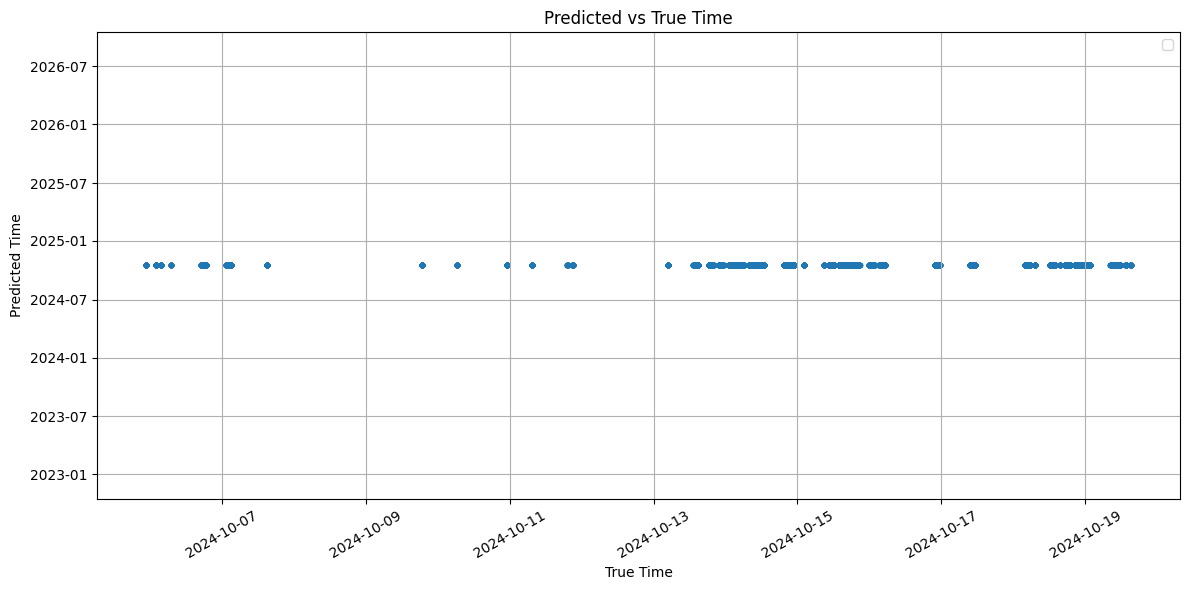

In [331]:
dataloader_final =  DataLoader(eazy_df, 2 ** 14, drop_last=True, num_workers=0, shuffle=False)


plot_time_predictions(time_model, dataloader_final, device, eazy_df[:][1].mean(), eazy_df[:][1].std())

In [270]:


# plot_predictions(time_model, DataLoader(eazy_df, 2 ** 14, drop_last=True, num_workers=12), device, coef=eazy_df[:][1].std())

In [78]:
torch.norm(eazy_df[0][0], dim=0).shape

torch.Size([64])

In [126]:
# (eazy_df[0][0] ** 2).sum(0) ** 0.5

In [125]:
#  torch.norm(eazy_df[0][0], 2, 0)

In [124]:
# (eazy_df[0][0] / torch.norm(eazy_df[0][0], 2, 0)).diff(1).norm(2, 0)

In [244]:
# train_time_regressor(SimpleRegressor(32), eazy_df, device=device)

Epoch 1:   0%|          | 0/1214800 [00:00<?, ?it/s]/home/motatasher/miniconda3/envs/DiplomaIsupov/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1:   0%|          | 1643/1214800 [00:03<41:00, 493.13it/s] 


KeyboardInterrupt: 

In [79]:
for a, b in eazy_df:
    print(b.shape)

torch.Size([100])


ValueError: could not determine the shape of object type 'Series'